# Generalized Lotka Volterra

We consider a Generalized Lotka Volterra system with $3$ populations
$$
\frac{\partial}{\partial t}u_i(t) = r_iu_i(t) - \sum_{j\neq i}\alpha_{ij}u_j(t)
-\alpha_{i,i}u_i(t) + c_iu_i(t) + \sum_{j \neq i} c_ju_j(t), i\in\{1, 2, 3\}
$$

More information on this ODE system can be found at [https://stefanoallesina.github.io/Sao_Paulo_School/intro.html#basic-formulation](https://stefanoallesina.github.io/Sao_Paulo_School/intro.html#basic-formulation)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

2024-09-20 10:34:47.791352: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx

import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [5]:
eqx_list = [
    [eqx.nn.Linear, 1, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 1],
    [jnp.exp]
]
key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "ODE")

In [6]:
init_nn_params = u.init_params()

Create a DataGenerator object

In [7]:
n = 320
batch_size = 32
method = 'uniform'
tmin = 0
tmax = 1

Tmax = 30
key, subkey = random.split(key)
train_data = jinns.data.DataGeneratorODE(
    subkey,
    n,
    tmin,
    tmax,
    batch_size,
    method=method
)

Initialize 3 set of neural network parameters for the 3 populations

In [8]:
init_nn_params_list = []
for _ in range(3):
    key, subkey = random.split(key)
    u = jinns.utils.create_PINN(subkey, eqx_list, "ODE", 0)
    init_nn_params = u.init_params()
    init_nn_params_list.append(init_nn_params)

### Model parameters




In [9]:
# initial conditions for each species
import numpy as onp
N_0 = onp.array([10., 7., 4.])
# growth rates for each species
growth_rates = jnp.array([0.1, 0.5, 0.8])
# carrying capacity for each species
carrying_capacities = jnp.array([0.04, 0.02, 0.02])
# interactions
# NOTE that for the interaction between the species **with itself** is always at position 0
# NOTE minus sign
interactions = -jnp.array([[0, 0.001, 0.001], [0, 0.001, 0.001], [0, 0.001, 0.001]])

Then, we proceed to define the set of parameters as required by the losses' `equation(self, ...)` methods. This is a `jinns.paramaters.ParamDict` object, with two fields for
 1. `nn_params`: the neural network parameters 
 2. `eq_params`: the equation parameters

__Note__ that the keys of the sub dictionaries `nn_params` and `eq_params` (here `str(i)`) could differ !

In [10]:
init_params = jinns.parameters.ParamsDict(
    nn_params={str(i): init_nn_params_list[i] for i in range(3)},
    eq_params={
        str(i): {
            "carrying_capacity": carrying_capacities[i],
            "growth_rate": growth_rates[i],
            "interactions": interactions[i, :],
        }
        for i in range(3)
    },
)

Visualize the output of the neural networks with the random initialization.

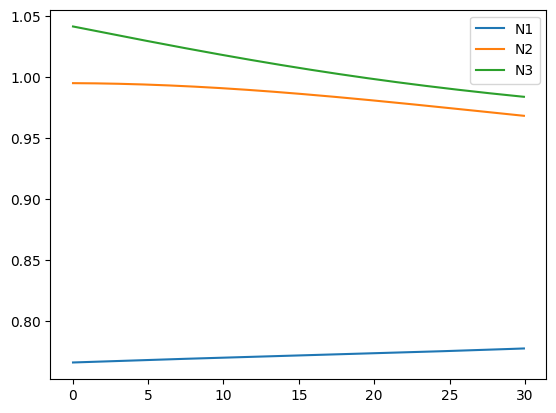

In [11]:
vectorized_u_init = vmap(lambda t: u(t, init_params.extract_params("0")), (0), 0)
vectorized_v_init = vmap(lambda t: u(t, init_params.extract_params("1")), (0), 0)
vectorized_w_init = vmap(lambda t: u(t, init_params.extract_params("2")), (0), 0)


plt.plot(train_data.times.sort(axis=0) * Tmax, vectorized_u_init(train_data.times.sort(axis=0)), label="N1")
plt.plot(train_data.times.sort(axis=0) * Tmax, vectorized_v_init(train_data.times.sort(axis=0)), label="N2")
plt.plot(train_data.times.sort(axis=0) * Tmax, vectorized_w_init(train_data.times.sort(axis=0)), label="N3")

plt.legend()

## Loss construction

We construct a SystemLossODE with GeneralizedLotkaVolterra losses for each population. Here `key_main` refer to the key in the dictionnary field `params.nn_params` which are the parameters for the main PINN of the equation (the PINN which represents the solution differentiated with respect to the `t`). In addition, `key_others` refer to the keys in `param.nn_params` which are the parameters for the PINNs interacting with `key_main`.

In [12]:
N1_dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(
    key_main="0", keys_other=["1", "2"], Tmax=Tmax
)
N2_dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(
    key_main="1", keys_other=["0", "2"], Tmax=Tmax
)
N3_dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(
    key_main="2", keys_other=["0", "1"], Tmax=Tmax
)


In [13]:
_, treedef_u = jax.tree.flatten(u)
treedef_u

PyTreeDef(CustomNode(PINN[('params',), ('slice_solution', 'eq_type', 'input_transform', 'output_transform', 'output_slice', 'static'), (slice(0, 1, None), 'ODE', <function create_PINN.<locals>.input_transform at 0x7fa0f4176e80>, <function create_PINN.<locals>.output_transform at 0x7fa0f4176f20>, None, _MLP(
  layers=[
    Linear(
      weight=None,
      bias=None,
      in_features=1,
      out_features=20,
      use_bias=True
    ),
    <wrapped function tanh>,
    Linear(
      weight=None,
      bias=None,
      in_features=20,
      out_features=20,
      use_bias=True
    ),
    <wrapped function tanh>,
    Linear(
      weight=None,
      bias=None,
      in_features=20,
      out_features=20,
      use_bias=True
    ),
    <wrapped function tanh>,
    Linear(
      weight=None,
      bias=None,
      in_features=20,
      out_features=1,
      use_bias=True
    ),
    <wrapped function exp>
  ]
))], [CustomNode(_MLP[('layers',), (), ()], [[CustomNode(Linear[('weight', 'bias'), 

In [14]:
loss_weights = jinns.loss.LossWeightsODEDict(dyn_loss=1, initial_condition=1 * Tmax)

loss = jinns.loss.SystemLossODE(
    u_dict={"0": u, "1": u, "2": u},
    loss_weights=loss_weights,
    dynamic_loss_dict={
        "0": N1_dynamic_loss,
        "1": N2_dynamic_loss,
        "2": N3_dynamic_loss,
    },
    initial_condition_dict={
        "0": (float(tmin), N_0[0]),
        "1": (float(tmin), N_0[1]),
        "2": (float(tmin), N_0[2]),
    },
)

/tmp/ipykernel_46183/3742859190.py:3: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  loss = jinns.loss.SystemLossODE(


In [15]:
loss.dynamic_loss_dict
# loss.derivative_keys_dyn_loss_dict

{'0': GeneralizedLotkaVolterra(
   Tmax=30,
   eq_params_heterogeneity=None,
   key_main='0',
   keys_other=['1', '2']
 ),
 '1': GeneralizedLotkaVolterra(
   Tmax=30,
   eq_params_heterogeneity=None,
   key_main='1',
   keys_other=['0', '2']
 ),
 '2': GeneralizedLotkaVolterra(
   Tmax=30,
   eq_params_heterogeneity=None,
   key_main='2',
   keys_other=['0', '1']
 )}

In [16]:
# Testing the loss function
train_data, batch = train_data.get_batch()

losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    batch
)
l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

DerivativeKeysODE(
  dyn_loss='nn_params',
  observations=None,
  initial_condition=None
)
nn_params 0


AttributeError: 'str' object has no attribute 'extract_params'

## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [16]:
params = init_params

In [17]:
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-3)

In [18]:
n_iter = int(2)

In [19]:
key, subkey = random.split(key)

In [20]:
params, total_loss_list, loss_by_term_dict, data, loss, _, _ , _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter
)

TypeError: Value '0' with type <class 'str'> is not a valid JAX type

In [21]:
total_loss_list[-1]

Array(4555.6255, dtype=float32)

# TO DELETE : test modif loss + solve

In [22]:
loss2 = jinns.loss.SystemLossODE(
    u_dict={"0": u, "1": u, "2": u},
    loss_weights=loss_weights,
    dynamic_loss_dict={
        "0": N1_dynamic_loss,
        "1": N2_dynamic_loss,
        "2": N3_dynamic_loss,
    },
    initial_condition_dict={
        "0": (float(tmin), N_0[0]),
        "1": (float(tmin), N_0[1]),
        "2": (float(tmin), N_0[2]),
    },
)

/tmp/ipykernel_39351/605340911.py:1: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  loss2 = jinns.loss.SystemLossODE(


In [23]:
jax.tree.structure(loss) == jax.tree.structure(loss2)

True

In [24]:
len(jax.tree.leaves(loss))

24

In [25]:
temp = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss2,
    n_iter=n_iter
)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function break_fun at /home/nicolas/Recherche/INRAE/PINN/jinns/jinns/solver/_solve.py:489 for while_cond. This value became a tracer due to JAX operations on these lines:

  operation a[35m:bool[20,1][39m = eq b b
    from line <string>:4:10 (__create_fn__.<locals>.__eq__)

  operation a[35m:bool[][39m = and b c
    from line <string>:4:10 (__create_fn__.<locals>.__eq__)

  operation a[35m:bool[20][39m = eq b b
    from line <string>:4:10 (__create_fn__.<locals>.__eq__)

  operation a[35m:bool[20,20][39m = eq b b
    from line <string>:4:10 (__create_fn__.<locals>.__eq__)

  operation a[35m:bool[20][39m = eq b b
    from line <string>:4:10 (__create_fn__.<locals>.__eq__)

(Additional originating lines are not shown.)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

## Results

Plot the loss values

In [ ]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show()

Plot the ODE solutions learned by the PINN

In [ ]:
u_est_fp = vmap(lambda t:u(t, params.extract_params("0")), (0), 0)
v_est_fp = vmap(lambda t:u(t, params.extract_params("1")), (0), 0)
w_est_fp = vmap(lambda t:u(t, params.extract_params("2")), (0), 0)


key, subkey = random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(subkey, n, tmin, tmax, batch_size, method)

import pandas as pd
ts = val_data.times.sort(axis=0)
df = pd.DataFrame(
    {
        "t": ts * Tmax, # rescale time for plotting
        "N1": u_est_fp(ts).squeeze(),
        "N2": v_est_fp(ts).squeeze(),
        "N3": w_est_fp(ts).squeeze(),
        "Method": "PINN"
    },
)
df.plot(x="t")

## Compare with the scipy solver
Code from Lorenzo Sala

In [25]:
import numpy as np
from scipy.integrate import odeint

# NOTE the following line is not accurate as it skips one batch

def lotka_volterra_log(y_log, t, eq_params):
    """
    Generalized Lotka-Volterra model for N bacterial species, with logarithmic transformation for stability.

    Parameters:
        y_log (array): Array of log-transformed bacterial populations.
        t (float): Time.
        params (tuple): Tuple of model parameters.

    Returns:
        dydt (array): Array of derivative of log-transformed bacterial populations with respect to time.
    """
    alpha, beta, gamma, _ = eq_params
    N = len(y_log)
    y = np.exp(y_log)
    dydt = np.zeros(N)

    for i in range(N):
        dydt[i] = y[i] * (alpha[i] - beta[i] * np.sum(y) - np.sum([gamma[j][i] * y[j] for j in range(N)]))

    dydt_log = dydt / y

    return dydt_log

# Define name bacteria
names = ['N1', 'N2', 'N3']
N = len(names)

# Define model parameters
death_rates = None
eq_params = (growth_rates, carrying_capacities, interactions, death_rates)

# Define initial bacterial populations
y0 = [10, 7, 4] #[0.26, 0.37, 0.57] #

# Define time points
Tmax = 30
t = ts * Tmax

############################

y0_log = np.log(y0)
y_log = odeint(lotka_volterra_log, y0_log, t, args=(eq_params,))
y = np.exp(y_log)

In [26]:
# comparative plots
df_scipy = pd.DataFrame(
    {
        "t": ts * Tmax, # rescale time for plotting
        "Method": "Scipy solver"
    } |
    {
        f"N{i+1}": y[:,i] for i in range(3)
    },
)



In [ ]:
import seaborn as sns
df_plot = pd.concat((df, df_scipy)).melt(id_vars=['Method', "t"], var_name="Population", value_name="Solution")
sns.relplot(df_plot, kind='line', x='t', y='Solution', hue='Population',  style='Method', height=4, aspect=2)